In [199]:
import numpy as np
import matplotlib.pyplot as plt
from sjoert.stellar import flux2mag
import pandas as pd
import forced_phot as fp #import flux_jy, chi2, gaussian, chi2_peak_finder
from astropy.io import ascii
from scipy.constants import c,h,k
import os

param_label_dict = {'sigma_rise':r'$\sigma_{\text{rise}}$','tau_dec':r'$\tau_{\text{dec}}$',
                    'log10_sigma_rise':r'$\sigma_{\text{rise}}$','log10_tau_dec':r'$\tau_{\text{dec}}$',
                    'F_p':r'F$_{\text{peak}}$','peak_g':r'F$_{\text{p,g}}$','peak_r':r'F$_{\text{p,r}}$','MBH':r'$\log_{10}($M$_{\text{BH}}/M_{\odot})$',
                    'dmg':r'$\Delta$m$_g$','dmr':r'$\Delta$m$_r$','opt_df_over_rms':r'$\Delta$F$_{\text{g}}$/F$_{\text{rms}}$'}

#==
#Load in the data
dpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data'
fullcatalogue = pd.read_csv(os.path.join(dpath,'transient_catalogue.txt'))
# catalogue = fullcatalogue[fullcatalogue['in_selection']].iloc[:,:-2]

class_info = pd.read_csv(os.path.join(dpath,'transient_classinfo.txt'))
masked_class_info = class_info[class_info['fit_exists']]
#==
#get the df_over_rms data. These are yet another subset of the transients so we find them in the class_info frame
df_over_rms = ascii.read(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\ZTF_neoWISE_flares_parent.dat')[['name','df_over_rms']]
id_mask = np.isin(masked_class_info['ztf_id'].values,df_over_rms['name'])
class_info_for_rms = masked_class_info[id_mask]
#filter out zero MBHs
nonzero_mbh_for_rms = np.nonzero(class_info_for_rms['MBH'].values)
class_info_for_rms = class_info_for_rms.iloc[nonzero_mbh_for_rms]
df_over_rms_masked = df_over_rms[nonzero_mbh_for_rms]
#==

In [185]:
fullcatalogue['classified'].sum(),class_info['fit_exists'].sum()

(13456, 13456)

In [186]:
np.array_equal(fullcatalogue['ZTF_ID'][fullcatalogue['classified']].values,class_info['ztf_id'][class_info['fit_exists']].values)

True

In [187]:
class_info[class_info['fit_exists']].shape

(13456, 8)

In [188]:
sum(class_info[class_info['classification'] != 'Unknown']['MBH'] == 0)

157

In [189]:
def mbh_cumul_hist(density=True,save = False,catal=class_info) -> None:
    """Creates either a CDF or cumaltive sum distribution of black hole masses from transients, differentiating between 
       strong AGN (defined as delta m < 1 in at least one of the green and red filter).  
    

    Args:
        density (bool, optional): if True plots a CDF else a cumulative sum. Defaults to True.
        save (bool, optional): for saving the figure. Defaults to False.
        catal (pandas.DataFrame, optional): Dataframe holding the catalogue information, e.g. the classification and black hole mass. Defaults to class_info.
    """
    mbh_indx = np.nonzero(catal['MBH'].values)
    cat = catal.copy() #keep the original
    # cat = cat.iloc[mbh_indx] #filter out only the ones with known mbh data
    
    cat_masked = cat[cat['fit_exists'].values] #we need fit results to see if a burst is "strong"
    #create the mask to filter out the strong AGNs, so it needs to be an AGN, be a strong burst and have a non-zero Mbh (0 MBH means it is unknown)
    strongmask = (cat_masked['classification'].values == 'AGN') * (fullcatalogue[fullcatalogue['classified']]['strong'].values) * (cat_masked['MBH'] != 0)

    mbh_strong = cat_masked['MBH'][strongmask].values
    cat = cat.iloc[mbh_indx]
    agnmask = (cat['classification'].values == 'AGN') 
    mbh_other = cat['MBH'][agnmask].values

    n_bins = np.histogram_bin_edges(cat['MBH'].values,bins=30)

    fig,ax = plt.subplots()
    n, bins, patches = ax.hist(mbh_strong, n_bins, density=density, histtype='step',
                           cumulative=True, label='Extreme AGN flare')
    ax.hist(mbh_other, n_bins, density=density, histtype='step',
                           cumulative=True, label='Normal AGN flare')

    ax.set_xlabel(r'$\log_{10}\left(\text{M}_{\text{BH}}/M_{\odot}\right)$')
    if density: ylabel = "CDF"
    else: ylabel = 'Cumulative sum'
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()
    plt.show()

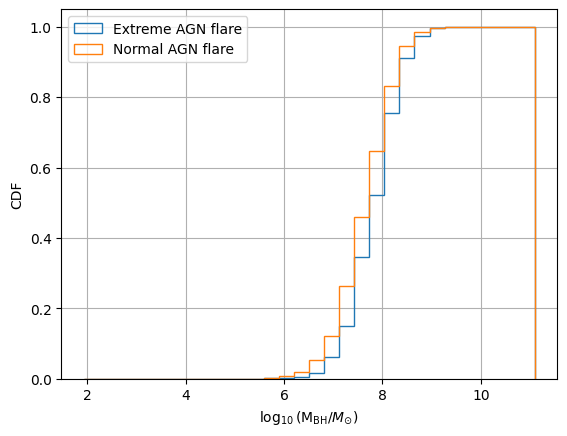

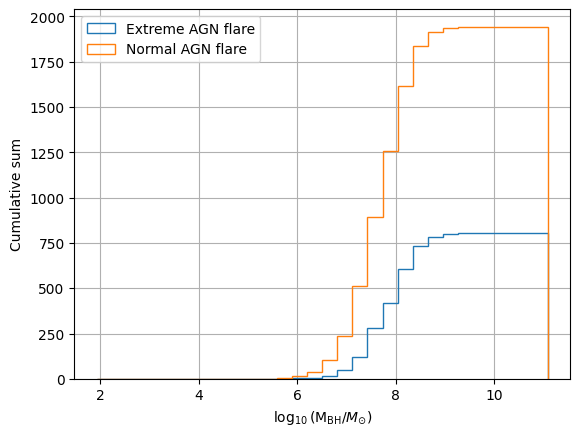

In [190]:
mbh_cumul_hist()
mbh_cumul_hist(density=False)

In [339]:
class_info_masked = class_info[class_info['fit_exists']] #class info for which there is known fit dta
catalogue_masked_full = fullcatalogue[fullcatalogue['classified']] #parameters for which there is an instance in the class_info data

good_fit_mask = catalogue_masked_full['fit_quality_good'].values * np.invert(np.isclose(catalogue_masked_full['log10_sigma_rise'].values,0,atol=1e-2)) *\
      np.invert(np.isclose(catalogue_masked_full['log10_tau_dec'].values,4,atol=1e-2)) * (class_info_masked['MBH'].values != 0)
class_info_masked = class_info_masked[good_fit_mask]
catalogue_masked = catalogue_masked_full[good_fit_mask]

plotfolder = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Code\FRP_TimvdVuurst\marginal_plots'

mapping = {'ZTF19aabbnzo':'18lna','ZTF18abjjkeo':'20hle','ZTF20aamqmfk':"20ddv",'ZTF19aapreis':'19dsg',
           'ZTF19aatubsj':'19fdr','ZTF19aaejtoy':'19aalc'}


def scatter_histogram_plot(x,y,logy=False,save=True,filtlist=['Unknown'],xlabel=None,ylabel=None,
                           mark_certain_flares=False,
                           class_info=class_info_masked):
    #x,y are names of the columns holding the data to be plotted

    #get the data from the masked dataframes. It must be the masked ones since we need to combine the two
    #you can also input straight arrays for ease. If you do so, input xlabel and ylabel as string for labeling axes manually
    if type(x) is str:
        try:
            xdata = catalogue_masked[x].values
        except KeyError:
            xdata = class_info_masked[x].values
    else:
        xdata = x
        x = xlabel
    if type(y) is str:
        try:
            ydata = catalogue_masked[y].values
        except KeyError:
            ydata = class_info_masked[y].values
    else:
        ydata = y
        y = ylabel

    colordict = {"AGN":'gray',"SN":"green","TDE":'blue','Unknown':'red'}
    markerdict = {"AGN":'s',"SN":"o","TDE":'P','Unknown':'p'}

    fig = plt.figure(layout='constrained')
    #main axis for the scatterplot
    ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    if logy: set_yscale = 'symlog'
    else: set_yscale = 'linear'

    try:
        ax.set(xlabel=param_label_dict[x],ylabel=param_label_dict[y],xlim=(min(xdata)-0.1,1.05*max(xdata)),ylim=(min(ydata)-0.1,1.05*max(ydata)),yscale=set_yscale)
    except:
        ax.set(xlabel=xlabel,ylabel=ylabel,xlim=(min(xdata)-0.1,max(xdata)),ylim=(min(ydata)-0.1,1.25*max(ydata)),yscale=set_yscale)
    
    #draw in the box if applicable
    sigma_cutoff = 2 # was np.log10(150)
    if (type(x) is str and type(y) is str):
        if x == 'log10_sigma_rise':
            if y == 'log10_tau_dec':
                ax.vlines(sigma_cutoff,0,np.log10(500),colors='black',linestyles='dashed',zorder=10,alpha=0.75)
            else:
                ax.vlines(sigma_cutoff,np.min(ydata),np.max(ydata),colors='black',linestyles='dashed',zorder=10,alpha=0.75)
        elif y == 'log10_sigma_rise':
            if x == 'log10_tau_dec':
                ax.hlines(sigma_cutoff,0,np.log10(500),colors='black',linestyles='dashed',zorder=10,alpha=0.75)
            else:
                ax.hlines(sigma_cutoff,np.min(xdata),np.max(xdata),colors='black',linestyles='dashed',zorder=10,alpha=0.75)
        
        if x == 'log10_tau_dec':
            if y == 'log10_sigma_rise':
                ax.vlines(np.log10(500),0,sigma_cutoff,colors='black',linestyles='dashed',zorder=10,alpha=0.75)    
            else:
                ax.vlines(np.log10(500),np.min(ydata),np.max(ydata),colors='black',linestyles='dashed',zorder=10,alpha=0.75)
        elif y == 'log10_tau_dec':
            if x == 'log10_sigma_rise':
                ax.hlines(np.log10(500),0,sigma_cutoff,colors='black',linestyles='dashed',zorder=10,alpha=0.75)    
            else:
                ax.hlines(np.log10(500),np.min(ydata),np.max(ydata),colors='black',linestyles='dashed',zorder=10,alpha=0.75)   

        if x == param_label_dict['MBH'] or x == 'MBH':
            ax.vlines(8,np.min(ydata),np.max(ydata),colors='black',linestyles='dashed',zorder=10,alpha=0.75)

    #create the marginal axes
    ax_histx = ax.inset_axes([0, 1.075, 1, 0.5], sharex=ax)
    ax_histy = ax.inset_axes([1.075, 0, 0.5, 1], sharey=ax)
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax_histx.set(ylabel='CDF')
    ax_histy.set(xlabel='Density')

    classifications = class_info['classification'].values
    if mark_certain_flares:
        flaremask = np.isin(class_info['ztf_id'].values,list(mapping.keys()))
        flare_x, flare_y = xdata[flaremask], ydata[flaremask]
        # xdata,ydata = xdata[np.invert(flaremask)], ydata[np.invert(flaremask)]
        # classifications = classifications[flaremask]

    # the scatter plot:
    zorder_dict = {"SN":9,"TDE":10,'AGN':6,'Unknown':7}
    for elem in np.unique(classifications):
        classmask = (classifications == elem)

        # now determine nice limits by hand:
        # binwidth = 0.25
        # xymax = max(np.max(np.abs(xdata[classmask])), np.max(np.abs(ydata[classmask])))
        # lim = (int(xymax/binwidth) + 1) * binwidth

        # bins = np.arange(-lim, lim + binwidth, binwidth)

        # if elem == 'Unknown':
        # ax.scatter(xdata[classmask],ydata[classmask],edgecolors=colordict[elem],marker=markerdict[elem],s=10,zorder=zorder_dict[elem],label=elem,alpha=0.5,facecolors='none')
        if elem in filtlist:
            continue #do not plot the classes you don't want to see
        else:
            ax.scatter(xdata[classmask],ydata[classmask],edgecolors=colordict[elem],marker=markerdict[elem],s=15,zorder=zorder_dict[elem],label=elem,facecolors='none')
            if mark_certain_flares:
                for i,n in enumerate(list(mapping.keys())):
                    ax.text(flare_x[i]*1.025,flare_y[i]*0.9,mapping[n],zorder=100,fontsize=8)
                    ax.scatter(flare_x[i],flare_y[i],edgecolors=colordict[elem],marker=markerdict[elem],s=30,zorder=zorder_dict[elem]+1,facecolors=colordict[elem])

                    
        ax_histy.hist(ydata[classmask], bins='auto', orientation='horizontal',histtype='step',density=True,color=colordict[elem])
        ax_histx.hist(xdata[classmask], bins='auto',histtype='step',density=True,color=colordict[elem],cumulative=True)
    


    plt.legend(bbox_to_anchor=(1.5,1.5),fontsize=12)
    if save:
        plt.savefig(os.path.join(plotfolder,f'{x}_vs_{y}.png'),dpi=500,bbox_inches='tight')
        plt.close()
    else:
        plt.show()


# scatter_histogram_plot('log10_sigma_rise','log10_tau_dec',False)
# scatter_histogram_plot('MBH','log10_sigma_rise',False)
# scatter_histogram_plot('dmg','log10_sigma_rise',False)
# scatter_histogram_plot('dmr','log10_sigma_rise',False)
# scatter_histogram_plot('log10_tau_dec','dmg',False)
# scatter_histogram_plot('log10_tau_dec','MBH',False)


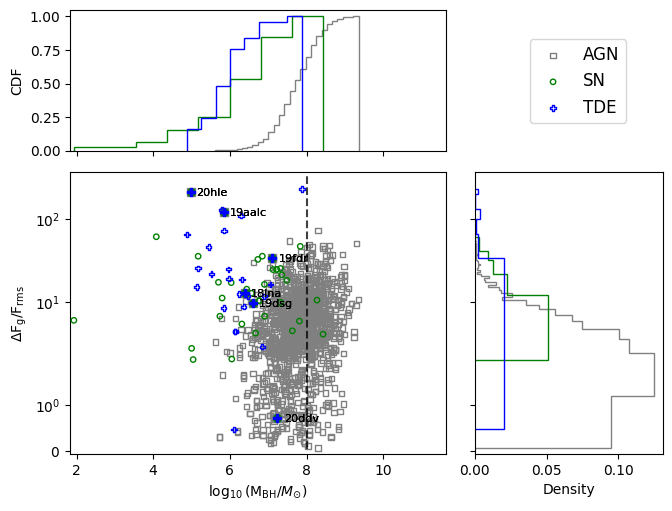

In [340]:
scatter_histogram_plot('MBH','opt_df_over_rms',logy=True,save=False,filtlist=['Unknown'],mark_certain_flares=True)

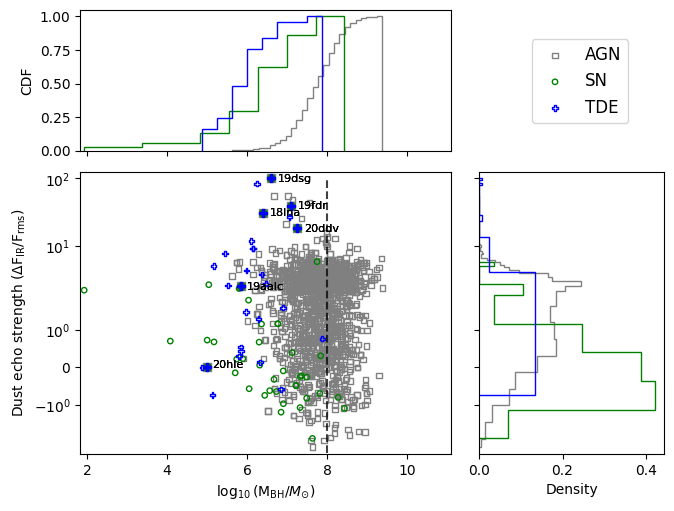

In [322]:
xplot,yplot = class_info_for_rms['MBH'].values,df_over_rms_masked['df_over_rms']

scatter_histogram_plot(xplot,yplot,logy=True,save=False,xlabel=param_label_dict['MBH'],
                       ylabel=r'Dust echo strength ($\Delta$F$_{\text{IR}}/\text{F}_{\text{rms}}$)',class_info=class_info_for_rms,mark_certain_flares=True)

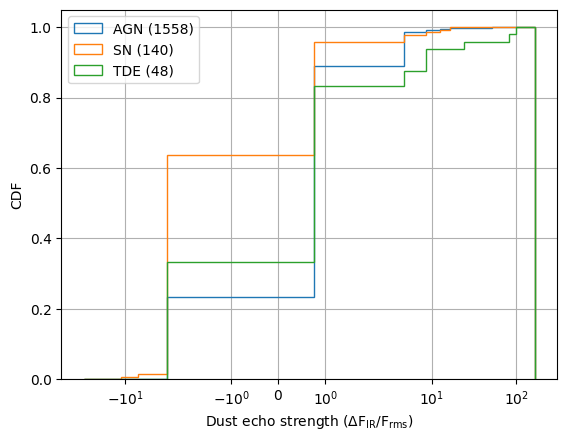

(13456,) (13456,)


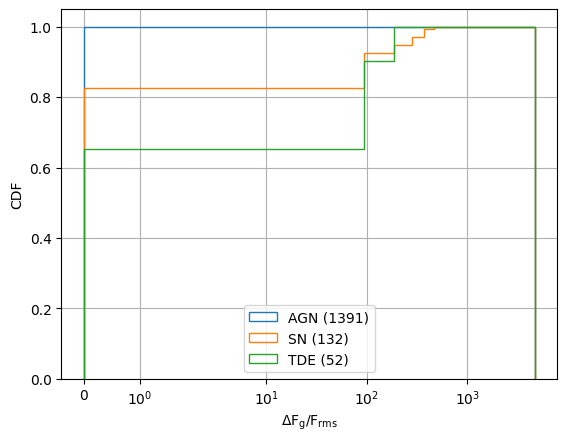

In [596]:
def dust_echo_CDF(density=True,n_bins=50):
    ztfmask = np.isin(class_info['ztf_id'].values,df_over_rms['name'])
    classes = class_info['classification'][ztfmask]


    dfrms_data = np.array(df_over_rms['df_over_rms'])
    n_bins = np.histogram_bin_edges(dfrms_data,bins=n_bins)

    fig,ax = plt.subplots()
    ax.set(xscale='symlog')
    for i,c in enumerate(np.unique(classes)):
        if c == 'Unknown':
            continue
        classmask = classes == c
        n, bins, patches = ax.hist(dfrms_data[classmask], n_bins, density=density, histtype='step',
                           cumulative=True, label=f'{c} ({classmask.sum()})')

    ax.set_xlabel(r'Dust echo strength ($\Delta$F$_{\text{IR}}/\text{F}_{\text{rms}}$)')
    if density: ylabel = "CDF"
    else: ylabel = 'Cumulative sum'
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()
    plt.show()

dust_echo_CDF()

def opt_df_over_rms_CDF(density=True,n_bins=50):
    classes = masked_class_info['classification']
    dfrms_data = catalogue_masked_full['opt_df_over_rms'].values

    quality_mask = catalogue_masked_full['fit_quality_good'].values

    classes = classes[quality_mask]
    dfrms_data = dfrms_data[quality_mask]

    n_bins = np.histogram_bin_edges(dfrms_data,bins=n_bins)

    fig,ax = plt.subplots()
    ax.set(xscale='symlog')
    for i,c in enumerate(np.unique(classes)):
        if c == 'Unknown':
            continue
        classmask = classes == c
        n, bins, patches = ax.hist(dfrms_data[classmask], n_bins, density=density, histtype='step',
                           cumulative=True, label=f'{c} ({classmask.sum()})')

    ax.set_xlabel(r'$\Delta$F$_{\text{g}}/\text{F}_{\text{rms}}$')
    if density: ylabel = "CDF"
    else: ylabel = 'Cumulative sum'
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()
    plt.show()

opt_df_over_rms_CDF()

### Trying some stuff with keras / ML
This is a MLP now, very simple with two layers. There's very little TDEs with well-known parameters (there's 55), so it's quite hard to train a model well.

In [563]:
y = masked_class_info['classification'].to_numpy()
unknownmask = (y != 'Unknown') * catalogue_masked_full['fit_quality_good'].values
y = y[unknownmask]
Mbh = masked_class_info['MBH'].to_numpy()[unknownmask]

X = catalogue_masked_full[['ZTF_ID','dmg','log10_sigma_rise','log10_tau_dec','opt_df_over_rms']][unknownmask]
x_ztfs = X['ZTF_ID'].values
# df_over_rms_mask = np.isin(x_ztfs,np.array(df_over_rms['name']))
# df_over_rms_mask2 = np.isin(np.array(df_over_rms['name']),x_ztfs)
# X = X[df_over_rms_mask]
X.drop('ZTF_ID',axis=1,inplace=True)
# X['df_over_rms'] = df_over_rms['df_over_rms'][df_over_rms_mask2]
X = X.to_numpy()
# y = y[df_over_rms_mask]

In [564]:
X.shape

(1575, 4)

In [565]:
np.random.seed(153286)
shuffle_array = np.random.rand(y.shape[0])
perm = np.argsort(shuffle_array)
X = X[perm]
y = y[perm]

In [566]:
y[y == 'TDE'] = 0
y[y == 'SN'] = 1
y[y == 'AGN'] = 2

In [572]:
import tensorflow as tf

Xtrain,ytrain = X[:1350],y[:1350]
Xtest,ytest = X[1350:],y[1350:]
ytrain_onehot = tf.keras.utils.to_categorical(ytrain)
ytest_onehot = tf.keras.utils.to_categorical(ytest)


In [573]:
print(np.sum(y == 0))

52


In [574]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(Xtrain.shape[1],)))
model.add(tf.keras.layers.Dense(128))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(3,activation='softmax'))
# model.summary()

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# model.summary()
training_results = model.fit(Xtrain, 
                             ytrain_onehot, 
                             epochs=25, 
                             batch_size=64)

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7192 - loss: 2.1614
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8777 - loss: 1.2175 
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9159 - loss: 0.7410
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9000 - loss: 0.5045 
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9195 - loss: 0.3005 
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9122 - loss: 0.3351 
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9164 - loss: 0.2685 
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9061 - loss: 0.4056 
Epoch 9/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9109 - loss: 0.2720 
Epoch 10/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9150 - loss: 0.2679 
Epoch 11/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9152 - loss: 0.2404 
Epoch 12/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


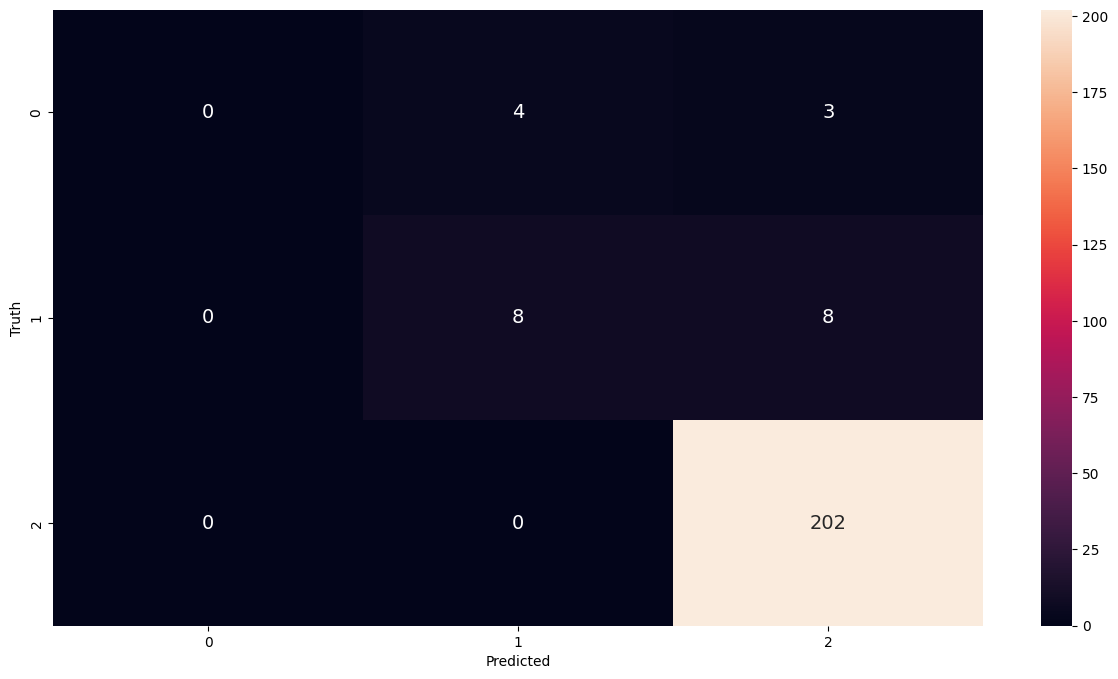

In [575]:
predictions = model.predict(Xtest)
labels = ['TDE','SN','AGN']
predicted_labels = [np.argmax(i) for i in predictions]
# Convert one-hot encoded labels to integers.
# y_test_integer_labels = tf.argmax(ytest_onehot, axis=1)
# print(ytest)
# # Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=ytest.astype(float), predictions=predicted_labels)
 
# # Plot the confusion matrix as a heatmap.
plt.figure(figsize=[15, 8])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
# plt.imshow(cm)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


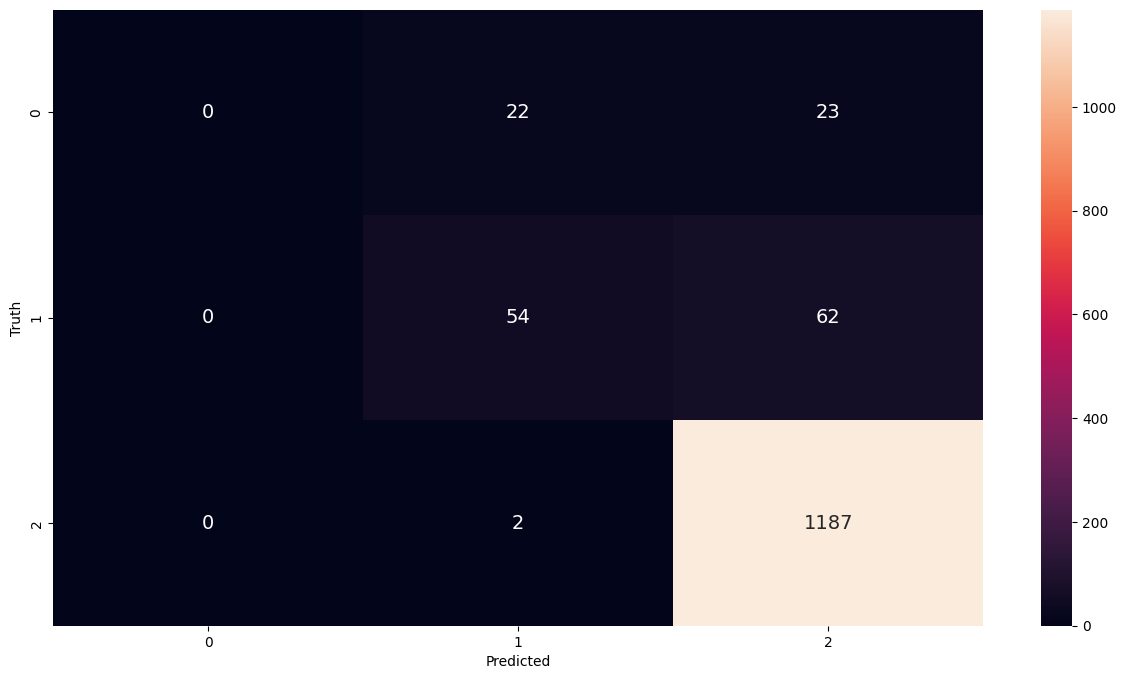

In [576]:
predictions = model.predict(Xtrain)
labels = ['TDE','SN','AGN']
predicted_labels = [np.argmax(i) for i in predictions]
# Convert one-hot encoded labels to integers.
# y_test_integer_labels = tf.argmax(ytest_onehot, axis=1)
# print(ytest)
# # Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=ytrain.astype(float), predictions=predicted_labels)
 
# # Plot the confusion matrix as a heatmap.
plt.figure(figsize=[15, 8])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
# plt.imshow(cm)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()